# Single-particle Eigenstate Thermolization in Polariton Hamiltonians. Photonic Wire Model
**Ribeiro Group Rotation Project A**

Brian Zhao, 09 Sept 2022

The following is adapted from Ribeiro, R. F. _Multimode Polariton Effects on Molecular Energy Transport and Spectral Fluctuations_. Commun Chem 2022, 5 (1), 1–10. https://doi.org/10.1038/s42004-022-00660-0.

### Model Hamiltonian
#### Cavity Hamiltonian
The empty cavity Hamiltonian is given by
$$
H_{\text{L}}=\sum_q \epsilon_q a_q^{\dagger}a_q,
$$
where
$$
\epsilon_q = \frac{\hbar c}{\sqrt{\epsilon}}\sqrt{q_0^2+q^2},
$$
where $q_0=\sqrt{(\pi/L_z)^2+(\pi/L_y)^2}$ is a constant, and $q=2\pi m/L$ ($m\in \mathcal{Z}$) are the _cavity modes_.

#### Matter Hamiltonian
The Hamiltonian for the molecules are given by
$$
H_{\text{M}}=\sum_{i=1}^{N_{\text{M}}}(\epsilon_{\text{M}}+\sigma_i)b_i^+b_i^-,
$$
where $b_i^+=|1_i\rangle\langle 0_i|$ and $b_i^-=|0_i\rangle\langle 1_i|$ creates and annihilates an excitation at the $i$-th molecule respectively, and $\sigma_i$ is drawn from a normal distribution with variance $\sigma^2$.

#### Light-matter Hamiltonian
Applying the Coulomb gauge in the rotating-wave approximation (ignoring double raising and lowering), we have
$$
H_{\text{LM}}=\sum_{j=1}^{N_{\text{M}}}\sum_q\frac{-i\Omega_{\text{R}}}{2}\sqrt{\frac{\epsilon_{\text{M}}}{N_{\text{M}}\epsilon_q}}\frac{\mu_j}{\mu_0}\left(e^{iqx_j}b_j^+a_q-e^{-iqx_j}a_q^{\dagger}b_j^- \right),
$$
where $\Omega_{\text{R}}=\mu_0\sqrt{\hbar\omega_0N_{\text{M}}/2\epsilon LL_yL_z}$, and $\mu_j$ is drawn from a normal distribution with variance $\sigma_{\mu}^2$.

We assume there is only one photon.

In [97]:
import numpy as np
import scipy.constants as cst
import matplotlib.pyplot as plt

q_to_ev = cst.c*cst.hbar/cst.e

class QuantumWire:
    
    def __init__(self, num_mol, omega_r, a, Ly, Lz, eps, em_mean, em_sigma, mu_sigma, f):

        self.num_mol = num_mol # Number of molecules
        
        # The restriction of N_c == N_m should be removed in future
        try:
            assert (num_mol-1)%2 == 0
        except AssertionError:
            raise ValueError('num_mol needs to be 2N+1, where N is a positive integer!')
            
        self.n = int((num_mol-1)/2) # Number of *distinct* cavity modes
        self.omega_r = omega_r # Rabi splitting / eV
        self.a = a # Molecular spacing / nm
        self.Ly = Ly # y-length / nm
        self.Lz = Lz # z-length / nm
        self.L = num_mol*a # x-legnth /nm
        self.eps = eps # Polarisability
        self.em_mean = em_mean # Mean molecular excitation energy / eV
        self.em_sigma = em_sigma*omega_r # STD of molecular excitation energy / eV
        self.mu_sigma = mu_sigma # STD of ratio of mu_j/mu_0
        self.f = f # Fractional spread of molecular positions
        
        self.rng = np.random.default_rng() # Initialise our random number generator
        
        self.photon_energies = None
        self.mol_energies = None
        self.hamil = None
        self.eigvals = None
        self.eigvecs = None
        self.lp_eigvals = None
        self.up_eigvals = None
        self.lp_photonic_content = None
        self.up_photonic_content = None
        
    def e_q(self, m):
        return np.sqrt((np.pi/self.Lz)**2 + (np.pi/self.Ly)**2 + (2*np.pi*m/self.L)**2) * q_to_ev/np.sqrt(self.eps)

    def generate_hamil(self):
        
        self.photon_energies = np.array([self.e_q(_) for _ in range(-self.n,self.n+1)])
        self.cavity_modes = np.array([(_,_) for _ in self.photon_energies[self.n+1:]]).flatten()
        self.cavity_modes = np.insert(self.cavity_modes,0,self.photon_energies[self.n])
        self.mol_energies = np.array([self.rng.normal(self.em_mean, self.em_sigma) for _ in range(self.num_mol)])
        
        self.hamil = np.diag(np.concatenate([self.photon_energies,self.mol_energies])) # Fill in the diagonal elements
        self.hamil = self.hamil.astype('complex128')

        # Fill in the off-diagonal elements
        # We just fill in the light-matter block (first quadrant), and take the complex conjugate for the third quadrant.
        for j in range(self.num_mol,2*self.num_mol):
            # This is the matter loop, we put it outside so mu_j only needs to be drawn once
            mu_j = self.rng.normal(1, self.mu_sigma)
            for q in range(self.num_mol):
                # omega_q was already computed in _diag
                omega_q = self.photon_energies[q]
                self.hamil[q,j] = (self.omega_r/2)*np.sqrt(self.mol_energies[j-self.num_mol]/(self.num_mol*omega_q))*(mu_j)*np.exp(-((q*2*np.pi/(self.a*self.num_mol))*(self.a*(j-self.num_mol)+self.a*self.rng.uniform(-self.f,self.f))-0.5*np.pi)*1j)
                self.hamil[j,q] = np.conjugate(self.hamil[q,j])
    
    def diag_hamil(self):
        
        self.eigvals, self.eigvecs = np.linalg.eigh(self.hamil)
        self.lp_eigvals = self.eigvals[:self.num_mol]
        self.up_eigvals = self.eigvals[self.num_mol:]
        photonic_content = np.array([sum(np.conjugate(self.eigvecs[:self.num_mol,_])*self.eigvecs[:self.num_mol,_]) for _ in range(self.num_mol*2)])
        photonic_content = photonic_content.astype('float64')
        self.lp_photonic_content = photonic_content[:self.num_mol]
        self.up_photonic_content = photonic_content[self.num_mol:]

In [98]:
a = QuantumWire(num_mol=1001, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2.2, em_sigma=0.2, mu_sigma=0.05, f=0.1)

In [99]:
a.generate_hamil()
a.diag_hamil()

<ipython-input-97-8de6d4ba0cb4>:73: ComplexWarning: Casting complex values to real discards the imaginary part
  photonic_content = photonic_content.astype('float64')


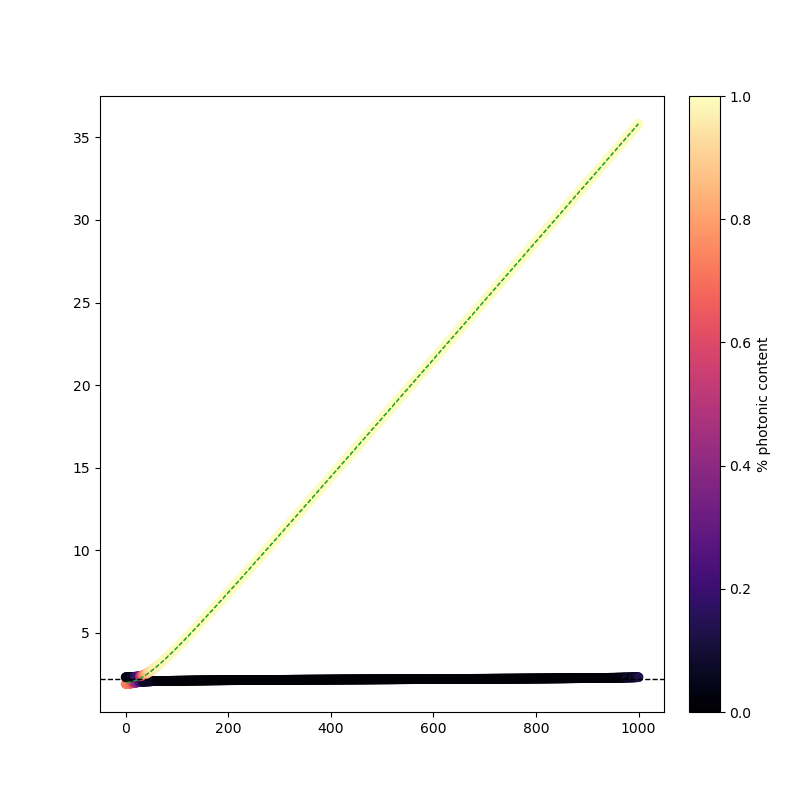

In [110]:
%matplotlib widget
f,ax = plt.subplots(figsize=(8,8))
im = ax.scatter(np.arange(0,1001),a.lp_eigvals[:],c=a.lp_photonic_content,cmap='magma',vmin=0,vmax=1)
ax.scatter(np.arange(0,1001),a.up_eigvals[:],c=a.up_photonic_content,cmap='magma')
ax.plot(np.arange(0,1001),a.cavity_modes,linestyle='--',color='tab:green',lw=1)
ax.axhline(y=a.em_mean,linestyle='--',color='black',lw=1)

f.colorbar(im, ax=ax, fraction=0.05, pad=0.04, label='% photonic content')

In [78]:
b = QuantumWire(num_mol=11, omega_r=0.3, a=10e-9, Ly=400e-9, Lz=200e-9, eps=3, em_mean=2, em_sigma=0, mu_sigma=0, f=0)

In [79]:
b.generate_hamil()
b.diag_hamil()

In [80]:
b.photonic_content

array([4.98689082e-01+0.j, 2.85668764e-04+0.j, 2.85668764e-04+0.j,
       2.73981955e-05+0.j, 2.73981955e-05+0.j, 7.38169146e-06+0.j,
       7.38169146e-06+0.j, 2.96606366e-06+0.j, 2.96606366e-06+0.j,
       1.47433846e-06+0.j, 1.47433846e-06+0.j, 5.01310918e-01+0.j,
       9.99714331e-01+0.j, 9.99714331e-01+0.j, 9.99972602e-01+0.j,
       9.99972602e-01+0.j, 9.99992618e-01+0.j, 9.99992618e-01+0.j,
       9.99997034e-01+0.j, 9.99997034e-01+0.j, 9.99998526e-01+0.j,
       9.99998526e-01+0.j])

In [83]:
sum(np.conjugate(b.eigvecs[:11,1])*b.eigvecs[:11,1])

(0.00028566876350571117+0j)

In [58]:
b.eigvals[0]

1.9158716441784323

In [88]:
dir(b.rng.bit_generator)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_cython__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__setstate_cython__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_benchmark',
 '_cffi',
 '_ctypes',
 '_seed_seq',
 'advance',
 'capsule',
 'cffi',
 'ctypes',
 'jumped',
 'lock',
 'random_raw',
 'state']